# Exploring simulations result

### This notebook is for exploratory analysis of the simulation results. It expects two files 
- variable named as "network_json_file" for network results file 
- variable named "json_file" for simulaton results

While network structure remains same, there is difference in values of alpha in each simulation files which were generated with random seeds. 

**Note:** the initial state for each alpha values are not same in this analysis.

In [1]:
import json
import pandas as pd
import numpy as np

import utilities
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
%matplotlib inline

In [3]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

In [4]:
sns.set(style='whitegrid', rc={'figure.figsize':(11, 8)}, font_scale=1.5) # setting seaborn style

### Description of dataset

Dataset was created from the simulation of 100 time steps for 100 agents. First of all, the small world network was created using networkx and "newman_watts_strogatz_graph" with following parameters:
- number of nodes = num_agents (i.e. n = 100) 
- \# of neighbors in ring topology = 10
- probabiity of adding new edge = 0.5

For more details refer to __[Networkx Documentation](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.newman_watts_strogatz_graph.html)__ 

Once we have the network, for time denoted by t, the next knowledge space for any agent was computed for t=0 to t=99 with equation below. For each agent $A^i$ ( *where* $A^{i=1}$, $A^{i=2}$, ......, $A^{i=100}$) has k-bit knowledge space, in our case we have 10-bit knowledge space for now. At next time step i.e. t+1, each bit 'b' in k-bit knowledge space is updated with function as below (eqn. 1).

### Formulation 

\begin{equation*}
\tag{eqn. 1}
A_b^{i}(t+1) = f(\alpha(\sigma (\sum_{j=1}^n W^{ij} A_{b'}^{j} (t), A_\tau^i)) + (1-\alpha)C[s])
\end{equation*}

where, 
- n is the number of agents
- s is the state that agent is in at time 't' which is given by decimal value conversion from binary bits of knowledge bits 
- $A_b$ refers to the $b_{th}$ bit with $b\in{\{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}}$ 
- $A^j_{b'}$ is $j_{th}$ agent with $b_{th}$ bit not same as $A^i$ and $j\in{\{1,2,3, ........, n}\}$
- $\alpha \in {\{0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1\}}$ 

- $W^{ij} = 1$ if an agent $A^j$ is neighbor of agent $A^j$ else, $W^{ij} = 0$
<br>
<br>
- $\sigma$ = sigmoid function given by: $\frac{1}{1 + e^{-k(x-x_0)}}$ (refer to __[Wiki Logistic Function](https://en.wikipedia.org/wiki/Logistic_function))__ with $x_0 = A_\tau^i $ and $A_\tau^i$ acts as threshold for influence from  neighboring agents  and $x = (\sum_{j=1}^n W^{ij} A_{b'}^{j} (t))$

- C is the coherence matrix with dimension of $2^k \times k$ with 'k' being number of knowledge bits <br>
    - Each row in coherence matrix C gives the probability of changing k-bits when agent is on that particular state
    - The matrix C is generated such that, the random bit out of k-bit is assigned probability between (0.5 to 0.9) and the next bit is chosen assigned with half the previous probability and so on.

### Visualing agents network
Below is the code for displaying the network structure.

C:\Users\niraj\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


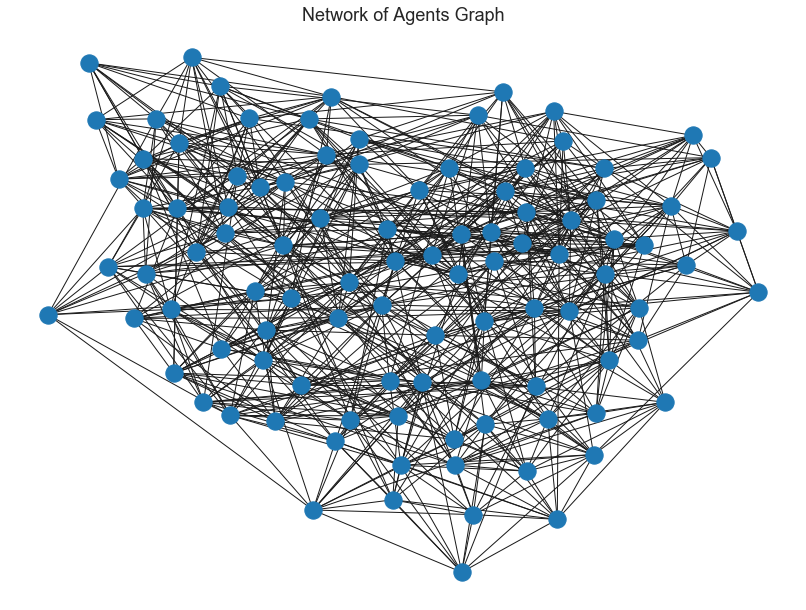

In [5]:
network_json_file = "simulations\\test_network.json"
network_data = []
network_df = pd.read_json(network_json_file, orient='records', lines=True)
network_dict = {i['Agent Name']:i['Neighbors'] for i in network_df.to_dict('records')}
# network_dict
graph = nx.from_dict_of_lists(network_dict)
nx.draw_spring(graph)
plt.title('Network of Agents Graph');

Below is the statistical description of the network graph where we can see in the above network 
the minimum number of neighbors were 11 and the maximum were 22 and median and average both were around 15.

In [6]:
network_df['Count Neighbors'] = network_df['Neighbors'].apply(lambda row: len(row))
description_df = round(network_df.describe(),2)
description_df = description_df.T
description_df.rename(columns={'count':'Total number of agents', 
                               'mean':'Average neighbors #',
                               '50%': 'Median neighbors #',
                                'min': 'Minimum neighbors #',
                                'max' : 'Maximum neighbors #',
                                 'std': 'Standard Deviation',
                                 '25%': 'Twenty five percentile (25%)',
                                '75%':'Seventy five percentile (75%)'}, inplace=True)
col_order = ['Minimum neighbors #', 'Maximum neighbors #' , 'Average neighbors #', 'Median neighbors #',  
             'Twenty five percentile (25%)', 'Seventy five percentile (75%)', 
             'Standard Deviation', 'Total number of agents']

description_df[col_order].T

Count Neighbors
Minimum neighbors #                      11.00
Maximum neighbors #                      22.00
Average neighbors #                      15.08
Median neighbors #                       15.00
Twenty five percentile (25%)             13.00
Seventy five percentile (75%)            16.00
Standard Deviation                        2.29
Total number of agents                  100.00

### Analysis of the simulation file
Below is the analysis of the single json simulation file.

In [7]:
json_file = "simulations\\test_result_7.json"
tmp_df = utilities.read_json_to_df(json_file) # read the json data file
raw_df = tmp_df.copy()

# below we are just chaning binary bits to corresponding state by converting to int values
tmp_df['Current_Knowledge_State'] = tmp_df['Current_Knowledge_State'].apply(lambda row: utilities.bool2int(row))
tmp_df['Next_Knowledge_State'] = tmp_df['Next_Knowledge_State'].apply(lambda row: utilities.bool2int(row))

In [8]:
def plot_heatmap(org_df, alpha_val=None):
    """This function is for plotting the heatmap of the dataframe which shows state transitions from current knowledge states
    next knowledge state"""
    if alpha_val:
        sel_df = org_df[org_df['alpha']==alpha_val]
    else:
        sel_df = org_df.copy()

    sim_current_states = set(sel_df['Current_Knowledge_State'].to_list())
    sim_next_states = set(sel_df['Next_Knowledge_State'].to_list())


    states_df = sel_df.groupby(['Current_Knowledge_State', 'Next_Knowledge_State']).size().to_frame('Count')

    states_df.reset_index(inplace=True)


    sorted_df = states_df.sort_values('Count', ascending=False)
    print('Top 10 highest frequent state transitions are: ')
    display(sorted_df.head(10))

    table = states_df.pivot(index='Current_Knowledge_State', columns='Next_Knowledge_State', values='Count')
    table.fillna(0, inplace=True)

    sns.heatmap(table.T, xticklabels=50, yticklabels=50, cbar_kws={"orientation": "horizontal"}, cmap="Reds_r");
    plt.title('Heatmap showing state transitions from one knowledge state to other for alpha = {}'.format(alpha_val));

    plt.figure()
    plt.title('Plot for the sparsity pattern of state transitions');

    plt.spy(table, markersize=1);

In [9]:
def plot_bit_changes(dataframe, alpha_val):
    print('Bit Changes for Alpha value {}'.format(alpha_val))
    
    df = dataframe[dataframe['alpha']==alpha_val]
    
    df = df[['Current_Knowledge_State', 'Time']]

    for i in range(10):
        df['bit{0}'.format(i)] = df['Current_Knowledge_State'].apply(lambda row: row[i]==1)

    bits_col = ['bit{}'.format(i) for i in range(10)]
    z = df[['Time']+bits_col].melt(id_vars=['Time'])
    z['value'].replace({False:'0', True:'1'}, inplace=True)
    z = z.groupby(['Time','variable','value']).size().to_frame('# of Agents').reset_index()
    t = z[z['# of Agents'] == 100]
    t['value'] = t['value'].apply(lambda row: str(int(row)^1))
    t['# of Agents'] = 0
    z = pd.concat([z,t], ignore_index=True, sort=False)
    sns.catplot(data=z, x='Time', y='# of Agents', hue='value', col='variable', col_wrap=1, kind='point', height=5, aspect=4.5)
    plt.xticks(rotation=90);

### Analysis 1.1  **when $\alpha = 0$**

When $\alpha=0$ first we can look into what is the initialized states distribution of agents look like as below:



In [10]:
def state_count_plot(alpha_val, time_val):
    sns.set(rc={'figure.figsize':(25,7)}, font_scale=1.25)
    graph = sns.countplot(x='Current_Knowledge_State', data=tmp_df[(tmp_df['alpha']==alpha_val)&(tmp_df['Time']==time_val)]);
    plt.xlabel('State values')
    plt.ylabel('Number of Agents')
    plt.title('Distribution of states when alpha= {} at time t = {}'.format(alpha_val, time_val));

    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.01,height ,ha="center")
    
    plt.xticks(rotation=75);

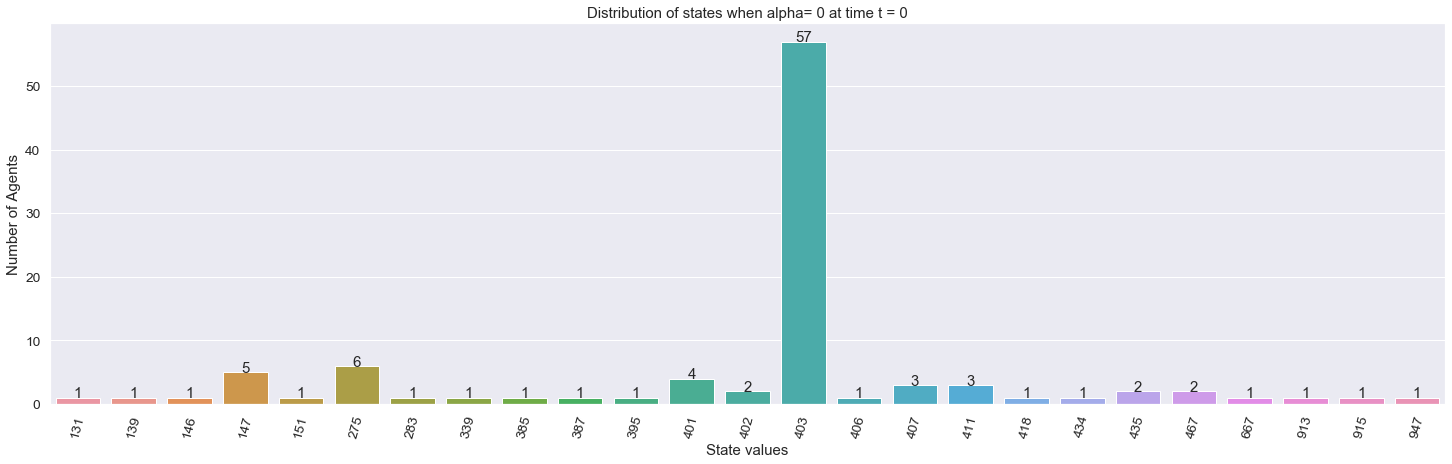

In [11]:
state_count_plot('0', 0)

We can see that in above figure, more than half of the agents are in state 403, i.e. in binary it is 0110010011

(**Note**: *This is something we discussed needs to update initialization such that each bits are equally likely to be 0 or 1*).  

Next we looked into the plot the heatmap to see state transitions as below. State transitions were based on the equation defined earlier.

Top 10 highest frequent state transitions are: 


Current_Knowledge_State  Next_Knowledge_State  Count
2041                      403                   403     23
2043                      403                   411     21
2205                      435                   434     16
3886                      743                   741     15
733                       163                   179     13
3469                      664                   664     12
2035                      403                   275     11
3619                      692                   692     11
2593                      504                   506     11
2181                      433                   435     11

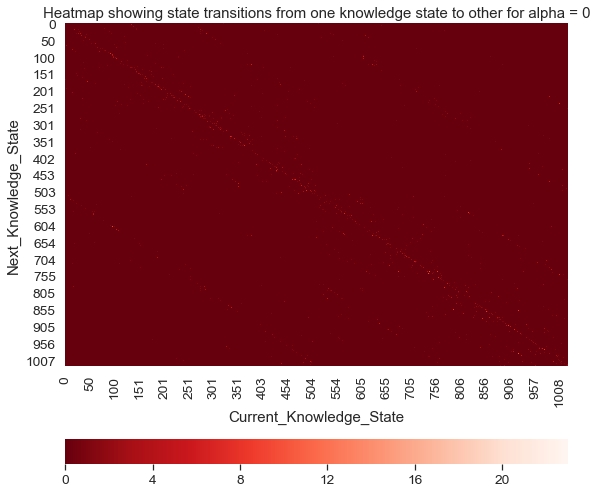

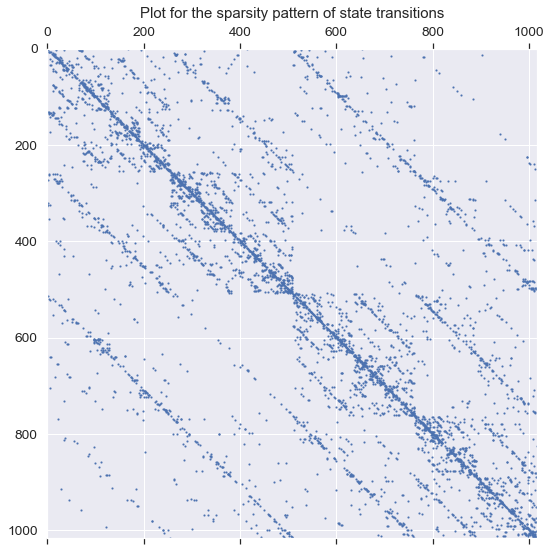

In [12]:
sns.set(rc={'figure.figsize':(9,9)}, font_scale=1.25)
plot_heatmap(tmp_df, '0')

From above figure, it seems like there is a dense pattern across diagonal and also there are other diagonal line structures. So, to look further first we tried to look into what is difference in jump of current state to next state or how is the pattern of difference in state transitions look like.

0     16    256   2     1     8     32    128   64    512   4    \
diff state  15.53  5.48  4.88  4.85  4.77  4.76  4.57  4.54  4.31  4.06  3.85   

             12    192   24    96    3     48    6     384  254  
diff state  0.83  0.77  0.77  0.72  0.68  0.68  0.68  0.68  0.6

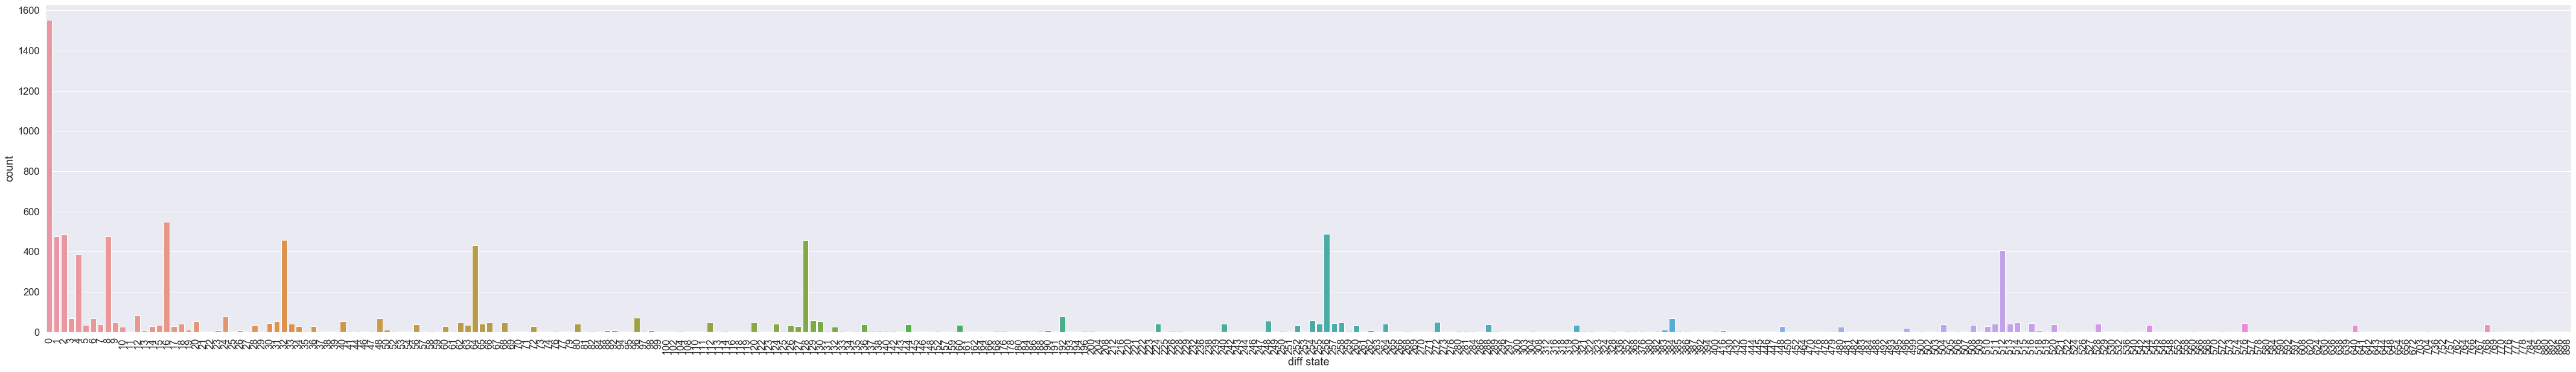

In [13]:
sns.set(rc={'figure.figsize':(45,10)})
x = tmp_df[tmp_df['alpha']=='0']
x['diff state'] = abs(x['Current_Knowledge_State']-x['Next_Knowledge_State'])
sns.set(style='darkgrid', rc={'figure.figsize':(75,10)}, font_scale=1.5)
sns.countplot(data=x, x='diff state');
plt.xticks(rotation=90);
pd.DataFrame(x['diff state'].value_counts(normalize=True).sort_values(ascending=False)*100).head(20).T

In above figure all the spikes occur when states values to some power of 2 i.e. $2^i$ where $i \in \{0,1,2,3,4,5,6,7,8,9\}$.
We also can see that around 15.5% of times there were no state transitions. Also, it seems the difference between states are more towards even than odd.

Next, we just checked number of times each bits were flipped during 10,000 transitions such that we expect every bits to be flipped somewhat equally. However, some of the state may flip 2 bits, 3 bits or so on as well. Note that above dataframe only shows top 20 difference state values.

In [14]:
def bitchanges(row_val):
    n_bits = len(row_val['Current_Knowledge_State'])
    bit_tracker = []
    for i in range(n_bits):
        if row_val['Current_Knowledge_State'][i] != row_val['Next_Knowledge_State'][i]:
            bit_tracker.append(1)
        else:
            bit_tracker.append(0)
    return np.array(bit_tracker)

In [15]:
x = raw_df[raw_df['alpha']=='0']

x['tracker'] = x.apply(lambda row : bitchanges(row), axis=1)
flipped_df = pd.DataFrame({'bit{}'.format(i):sum(x['tracker'].str[i]) for i in range(10)}, index=[0]).T
flipped_df.columns = ['Number of times bit was flipped']
flipped_df

Number of times bit was flipped
bit0                             1406
bit1                             1443
bit2                             1233
bit3                             1428
bit4                             1448
bit5                             1344
bit6                             1297
bit7                             1382
bit8                             1435
bit9                             1328

In [16]:
sum(flipped_df['Number of times bit was flipped'])

13744

so, unless $9^{th}$ or $10^{th}$ bit is not flipped, the state remains somewhat within a box of transitions i.e. 256. If each bits are equally likely to flip then other 8 bits will have majority. So, I think it may be reason we see much of the dense in sparse plot within the diagonal area. As we saw spikes so from diagonal, the random movement still will have similar difference of state transitions which makes the lines. I think it may have been different, if the coherence matrix design could allow any number of bits to flip. However, as of now most likely only 1 or 2 bits are allowed to flip.

Next we look into for each bit in k-bits, how number of agents that bits turned on (i.e. 1) or off (i.e. 0) over time period. As we saw above 57 agents were at state 403 at t=0, i.e. in binary it is 0110010011, which may be one reason large gap in initial separation.

The x-axis in the figure below denotes the time 't' where t = 0, 1, .......... , 100 and two different colors in y-axis is number of agents with k-th bit 0 (colored blue) and 1 (colored orange).

Bit Changes for Alpha value 0


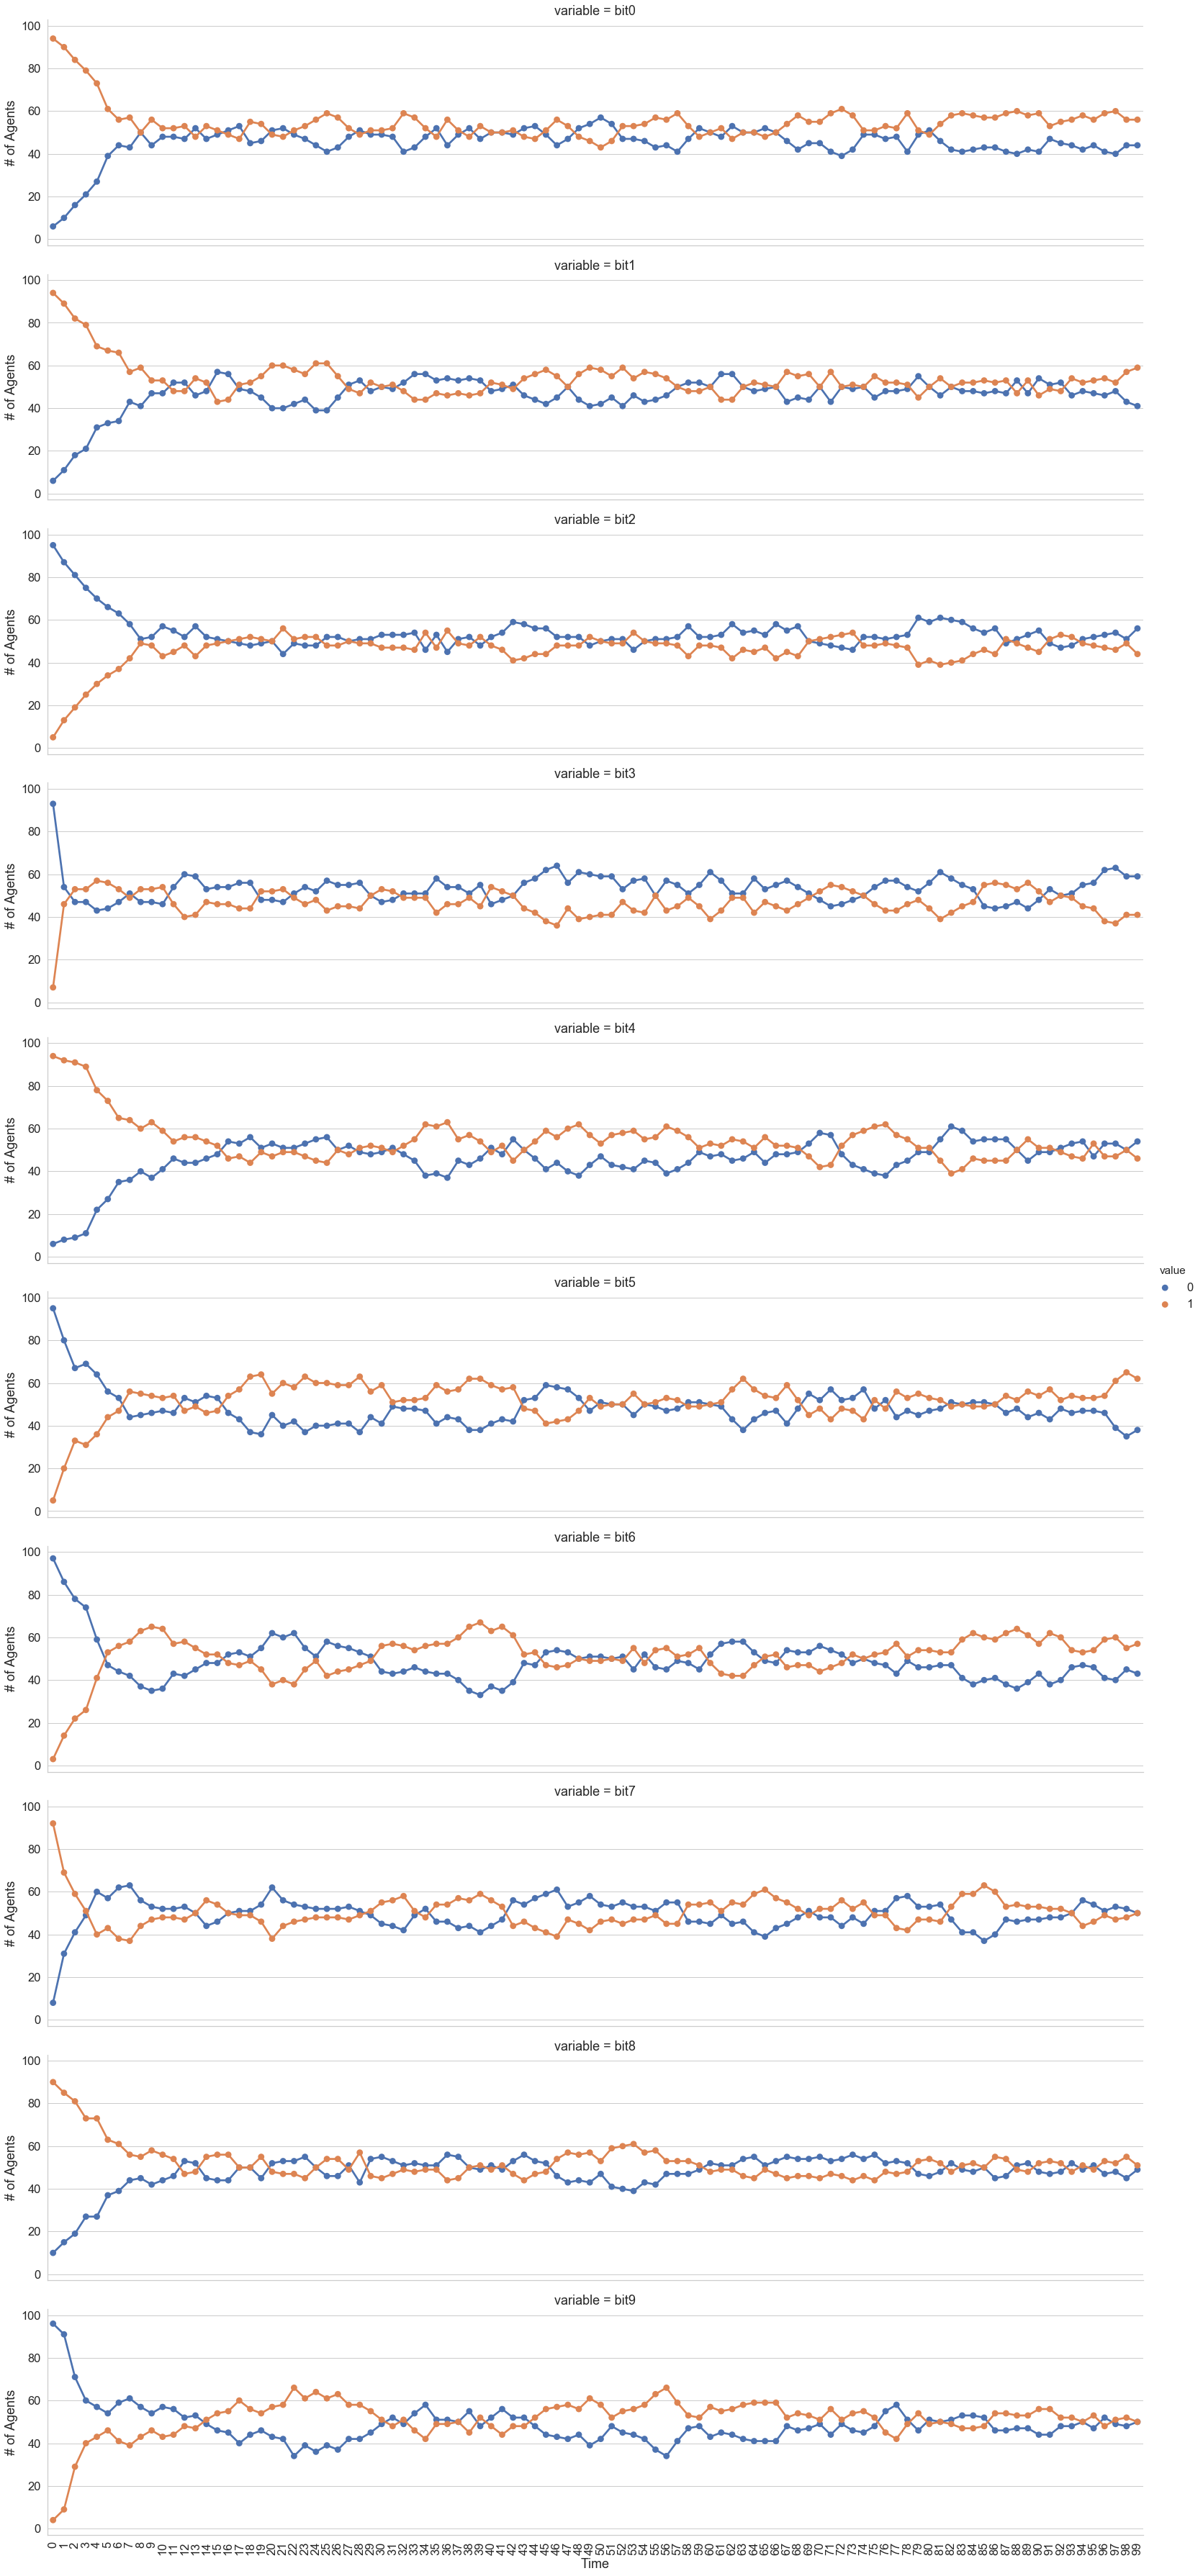

In [17]:
sns.set(style='whitegrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
x = plot_bit_changes(raw_df, '0')

In above figure, in the long run, we see there are half agents for both bits. We may have to extend time period to check if they converge or as discussed we can look into random walks.

### Analysis 1.2  **when $\alpha = 0.5$**

When $\alpha=0.5$ first we can look into what is the initialized states distribution of agents look like as below:

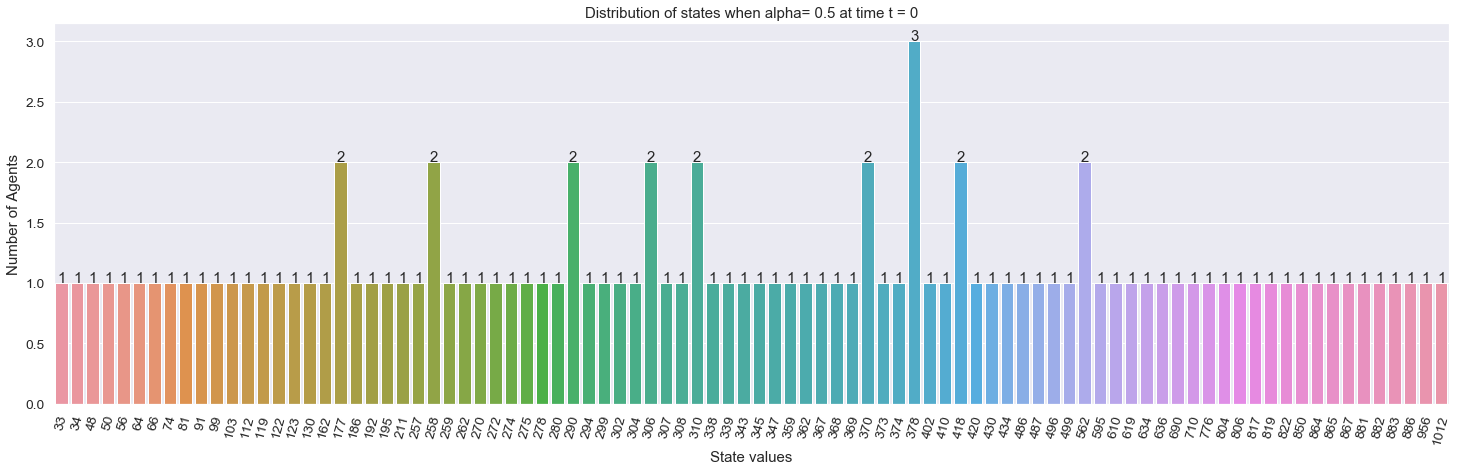

In [18]:
state_count_plot('0.5', 0)

**IMPORTANT NOTE:** If we compare this above with earlier initial state, it is different but was expected to be same (*there is issue with generation on simulation which needs to be fixed*). However, I thought the analysis would somewhat show if the agents initial state would make differences.

Unlike when $\alpha=0$, here we do not see wide spread of initial states

Top 10 highest frequent state transitions are: 


Current_Knowledge_State  Next_Knowledge_State  Count
1497                      115                   115    121
1477                      115                    51     63
3891                      370                   370     55
1120                       99                    99     44
3962                      371                   371     38
1496                      115                   114     32
485                        51                    51     31
1415                      114                   115     31
3894                      370                   374     29
496                        51                   115     26

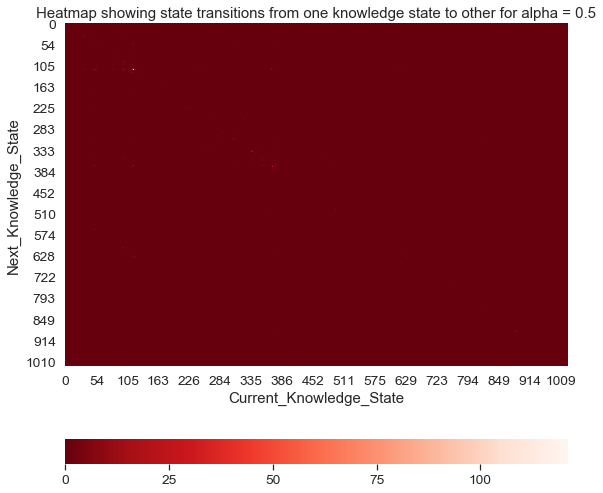

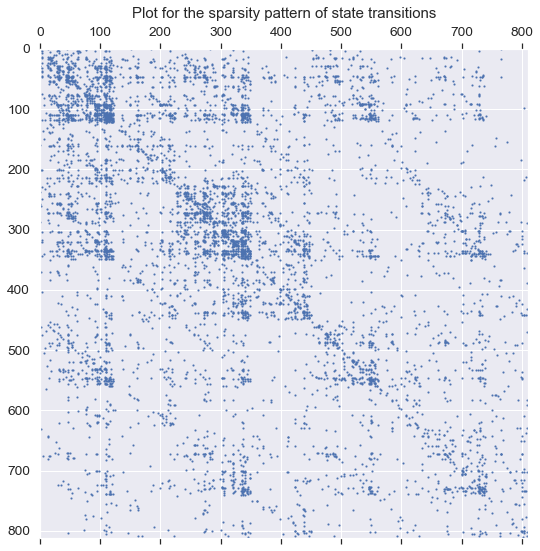

In [19]:
sns.set(rc={'figure.figsize':(9,9)}, font_scale=1.25)
plot_heatmap(tmp_df, '0.5')

0     64    256   16    1     4     2     8     32    128   512  \
diff state  9.66  3.39  3.23  3.06  2.94  2.84  2.76  2.56  2.25  1.99  1.83   

             192   12   24    80    48    248   320   3     5    
diff state  0.96  0.88  0.8  0.79  0.76  0.73  0.68  0.66  0.63

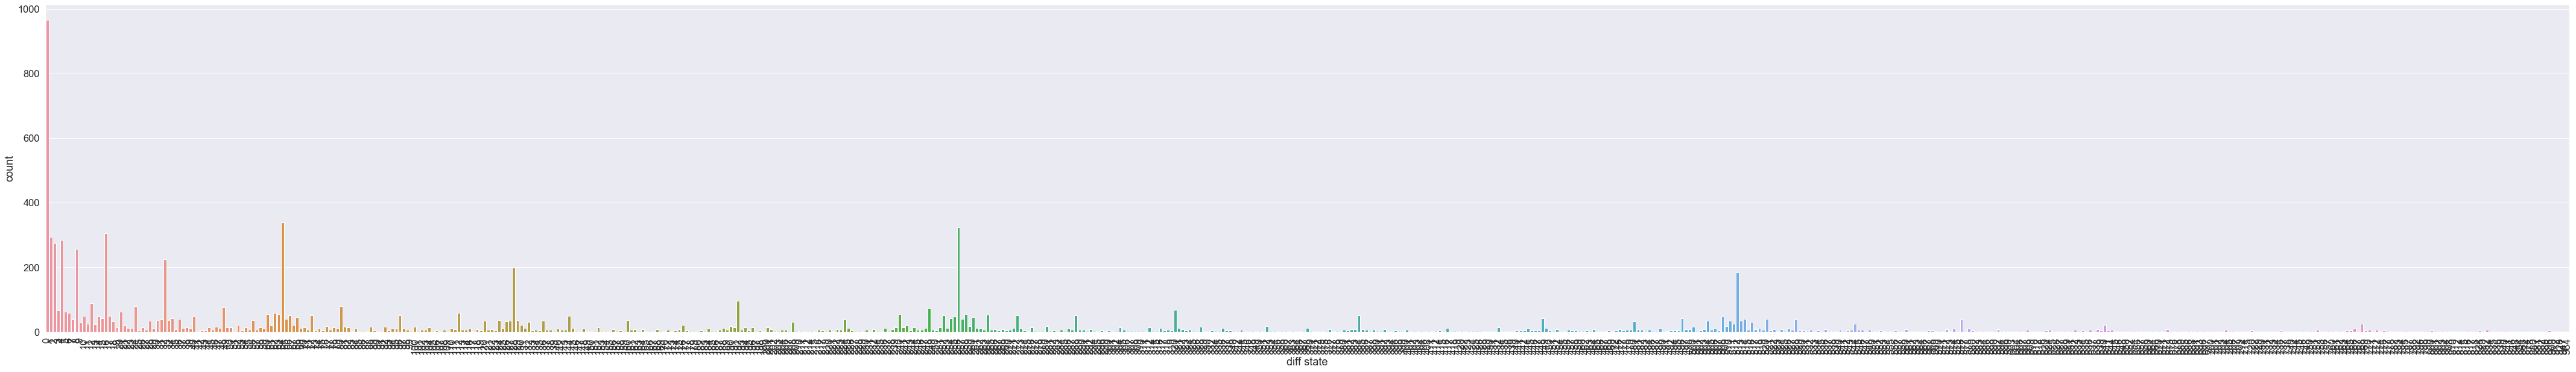

In [20]:
sns.set(rc={'figure.figsize':(45,10)})
x = tmp_df[tmp_df['alpha']=='0.5']
x['diff state'] = abs(x['Current_Knowledge_State']-x['Next_Knowledge_State'])
sns.set(style='darkgrid', rc={'figure.figsize':(75,10)}, font_scale=1.5)
sns.countplot(data=x, x='diff state');
plt.xticks(rotation=90);
pd.DataFrame(x['diff state'].value_counts(normalize=True).sort_values(ascending=False)*100).head(20).T

In above figure the spikes occur when states values to some power of 2 i.e. $2^i$ where $i \in \{0,1,2,3,4,5,6,7,8,9\}$.
However, the percentage is smaller than earlier found and seems more random as well which may show that the initialization in $\alpha=0$ may have some effect. 

Next, we just checked number of times each bits were flipped during 10,000 transitions such that we expect every bits to be flipped somewhat equally. However, some of the state may flip 2 bits, 3 bits or so on as well.

In [21]:
x = raw_df[raw_df['alpha']=='0.5']

x['tracker'] = x.apply(lambda row : bitchanges(row), axis=1)
flipped_df = pd.DataFrame({'bit{}'.format(i):sum(x['tracker'].str[i]) for i in range(10)}, index=[0]).T
flipped_df.columns = ['Number of times bit was flipped']
flipped_df

Number of times bit was flipped
bit0                             2174
bit1                             2180
bit2                             2277
bit3                             2106
bit4                             2412
bit5                             2003
bit6                             2588
bit7                             1780
bit8                             2447
bit9                             2046

In [22]:
sum(flipped_df['Number of times bit was flipped'])

22013

We see there were more number of bits flipped (22013 $\gt$ 13744) when in 0.5 in comparison of $\alpha=0$

Compared to alpha of value 0 when increased to 0.5 there is some little more frequent state transition as we see there were 15.53% no state transition while $\alpha=0$ compared to 9.66% when $\alpha=0.5$.

Next we look into for each bit in k-bits, how number of agents that bits turned on (i.e. 1) or off (i.e. 0) over time period. As initialized states are all over at t=0, it shows less gap in initial separation.

The x-axis in the figure below denotes the time 't' where t = 0, 1, .......... , 100 and two different colors in y-axis is number of agents with k-th bit 0 (colored blue) and 1 (colored orange).

Bit Changes for Alpha value 0.5


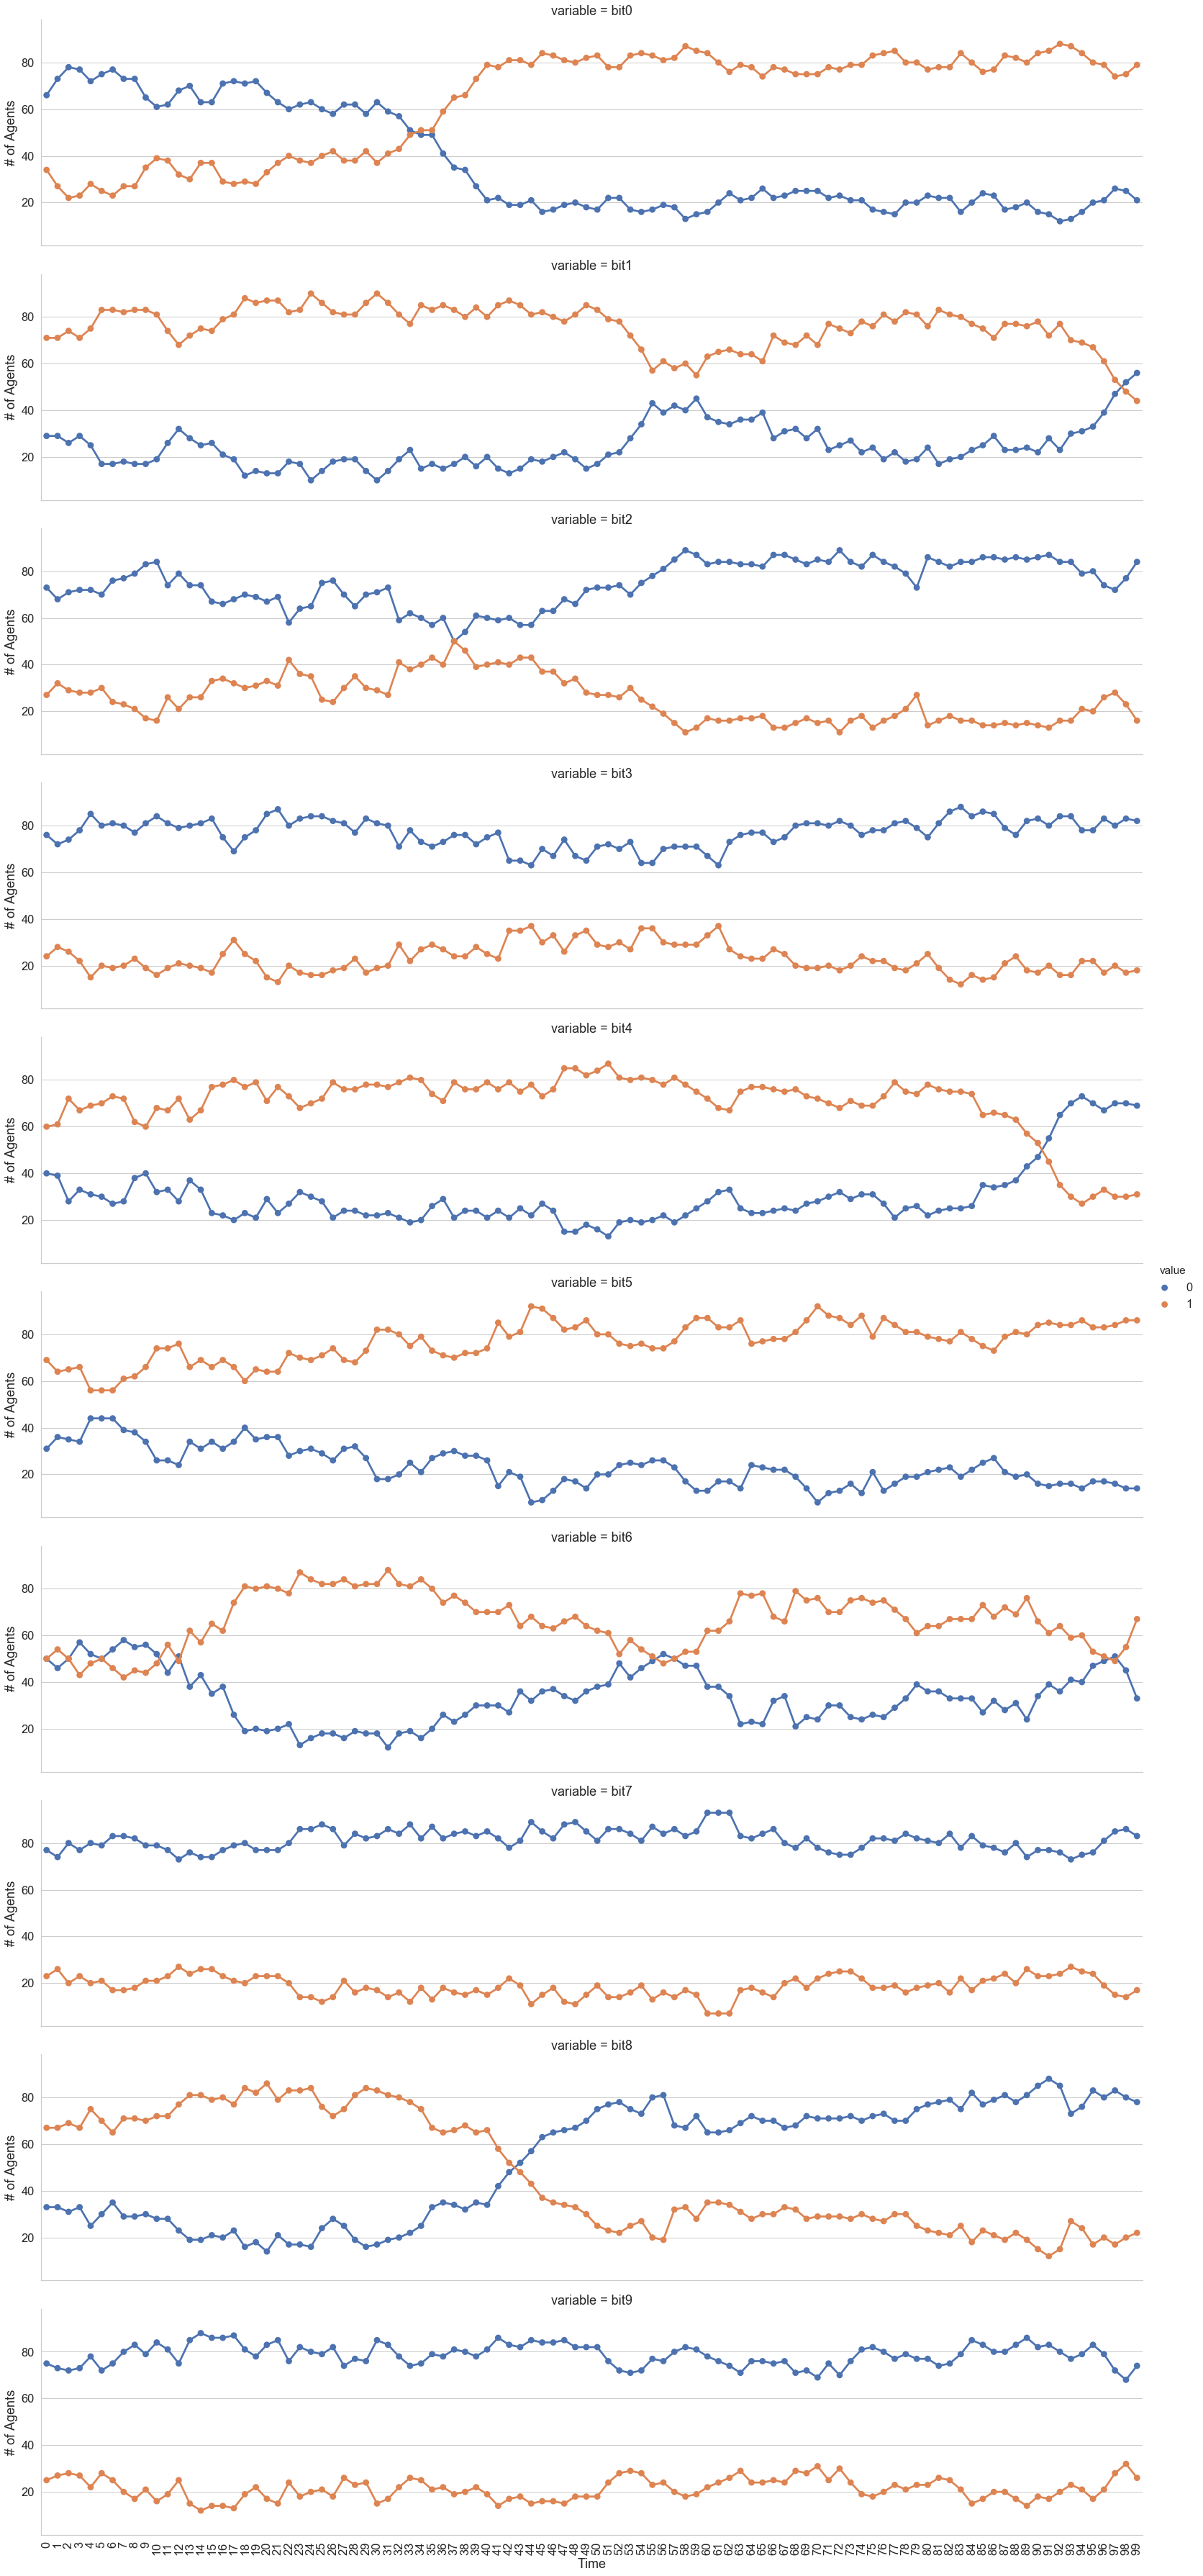

In [23]:
sns.set(style='whitegrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
x = plot_bit_changes(raw_df, '0.5')

### Analysis 1.3  **when $\alpha = 1.0$**

Increasing alpha to 1.0, first we looked into initial states of the agents.


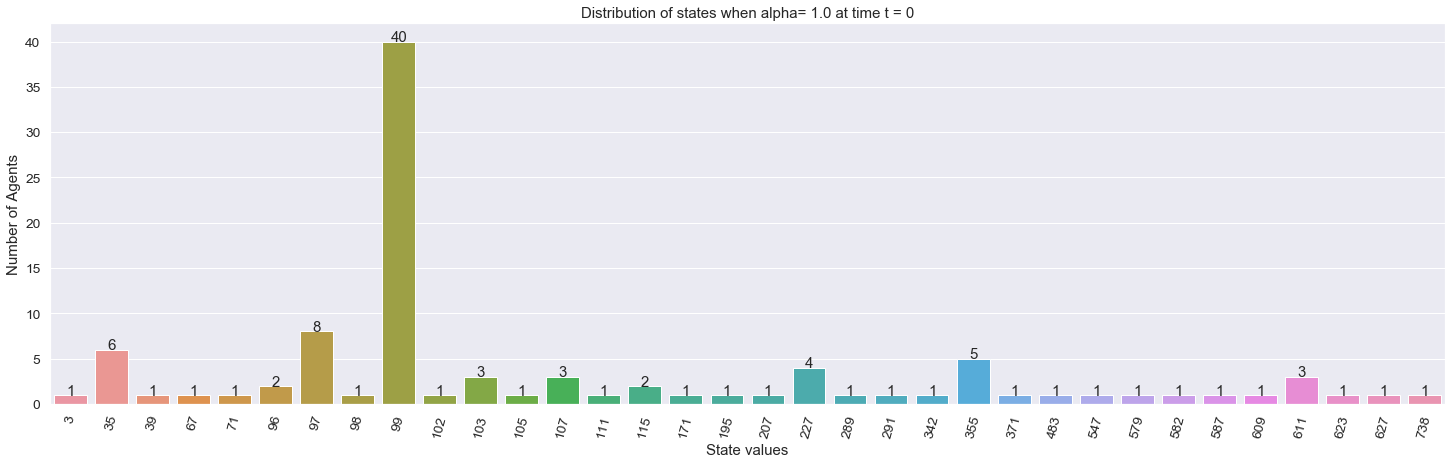

In [24]:
state_count_plot('1.0', 0)

We can see that in above figure, large number of agents are in state 99, i.e. in binary it is 0001100011

Next we looked into the plot the heatmap to see state transitions as below.

Top 10 highest frequent state transitions are: 


Current_Knowledge_State  Next_Knowledge_State  Count
461                       99                    99   4204
464                       99                   103    142
571                      103                    99    135
92                        35                    99    133
248                       67                    99    130
452                       99                    67    124
459                       99                    97    123
361                       97                    99    121
441                       99                    35    120
521                       99                   611    119

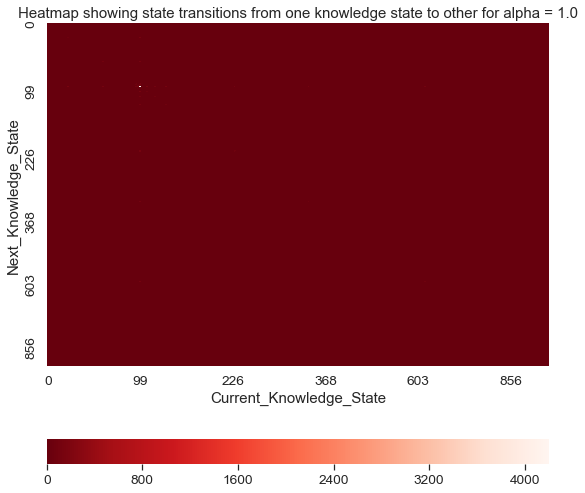

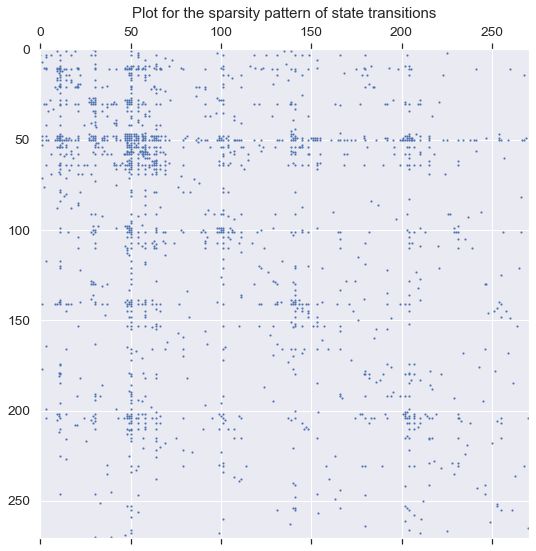

In [25]:
sns.set(rc={'figure.figsize':(9,9)}, font_scale=1.25)
plot_heatmap(tmp_df, '1.0')

It seems that states are more stable and change does not have frequently. In heatmap we see one bright spot and others are less visible.

We can check by number of differences in transition of states as below

0     4     32    2     64    16    128   256   512   8     1    \
diff state  50.73  3.58  3.47  3.46  3.37  3.17  3.04  2.95  2.87  2.81  2.77   

            96    6     192  384   48    24    3     320   15   
diff state  0.4  0.35  0.34  0.3  0.28  0.27  0.25  0.24  0.23

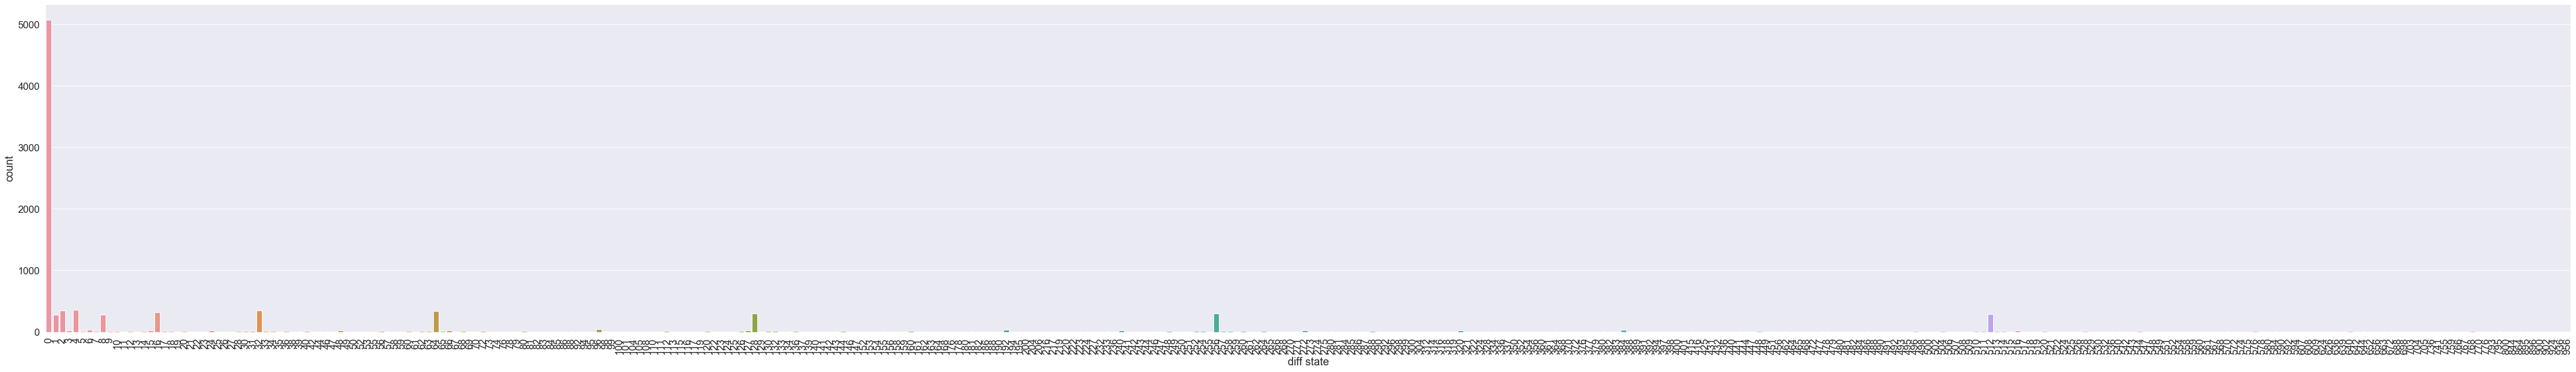

In [26]:
sns.set(rc={'figure.figsize':(45,10)})
x = tmp_df[tmp_df['alpha']=='1.0']
x['diff state'] = abs(x['Current_Knowledge_State']-x['Next_Knowledge_State'])
sns.set(style='darkgrid', rc={'figure.figsize':(75,10)}, font_scale=1.5)
sns.countplot(data=x, x='diff state');
plt.xticks(rotation=90);
pd.DataFrame(x['diff state'].value_counts(normalize=True).sort_values(ascending=False)*100).head(20).T

Here we can see around 50.73% of the total transitions, there were no state changes.

We checked if bits were flipped in similar number of times which shows although there were less flips compared to earlier, the number of flips were similar to different bits without considering agents and whether single bit was flipped in single transitions or multiple were flipped at a time.

In [27]:
x = raw_df[raw_df['alpha']=='1.0']

x['tracker'] = x.apply(lambda row : bitchanges(row), axis=1)
flipped_df = pd.DataFrame({'bit{}'.format(i):sum(x['tracker'].str[i]) for i in range(10)}, index=[0]).T
flipped_df.columns = ['Number of times bit was flipped']
flipped_df

Number of times bit was flipped
bit0                              733
bit1                              853
bit2                              795
bit3                              713
bit4                              811
bit5                              815
bit6                              842
bit7                              766
bit8                              757
bit9                              788

In [28]:
sum(flipped_df['Number of times bit was flipped'])

7873

Next we look into for each bit in k-bits, how number of agents that bits turned on (i.e. 1) or off (i.e. 0) over time period. As initialized states are 40 of them have same state at t=0, it shows more gap in initial separation. However, unlike $\alpha=0$, these do not get closer over time or cross over, the separation is maintained. As suggested we will check for different initialization state where difference in number of agents during initialization is less for bits.

The x-axis in the figure below denotes the time 't' where t = 0, 1, .......... , 100 and two different colors in y-axis is number of agents with k-th bit 0 (colored blue) and 1 (colored orange).

Bit Changes for Alpha value 1.0


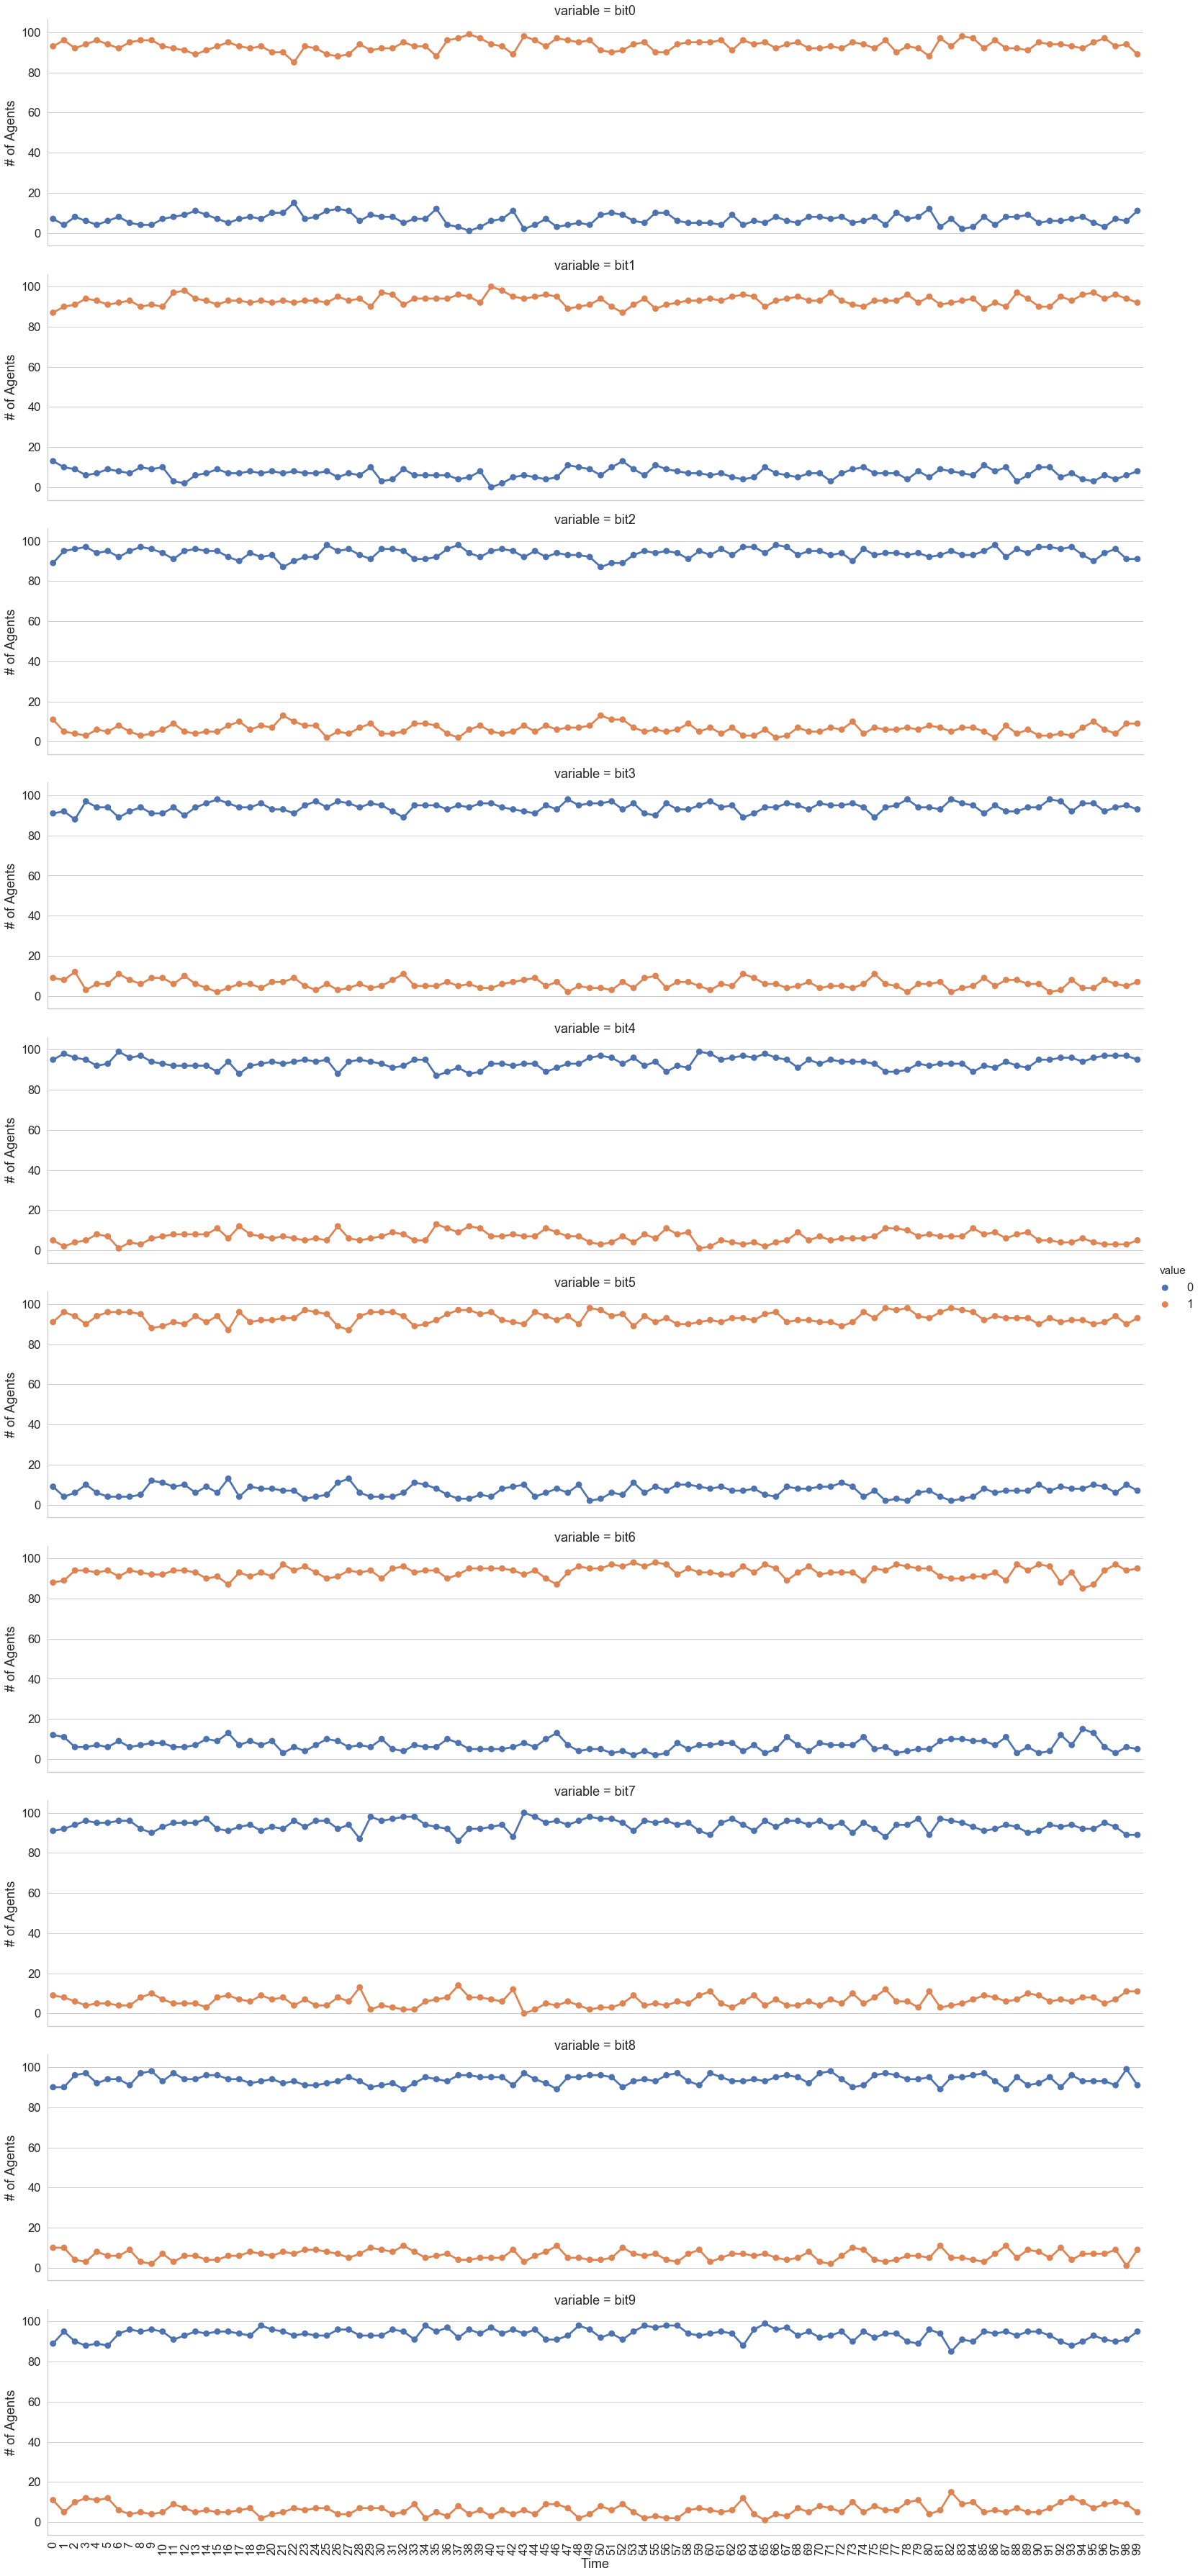

In [29]:
sns.set(style='whitegrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
plot_bit_changes(raw_df, '1.0')

Next looking at the figure below, we can see the most transition was to state = 99 which could either be no state change or change from other states.

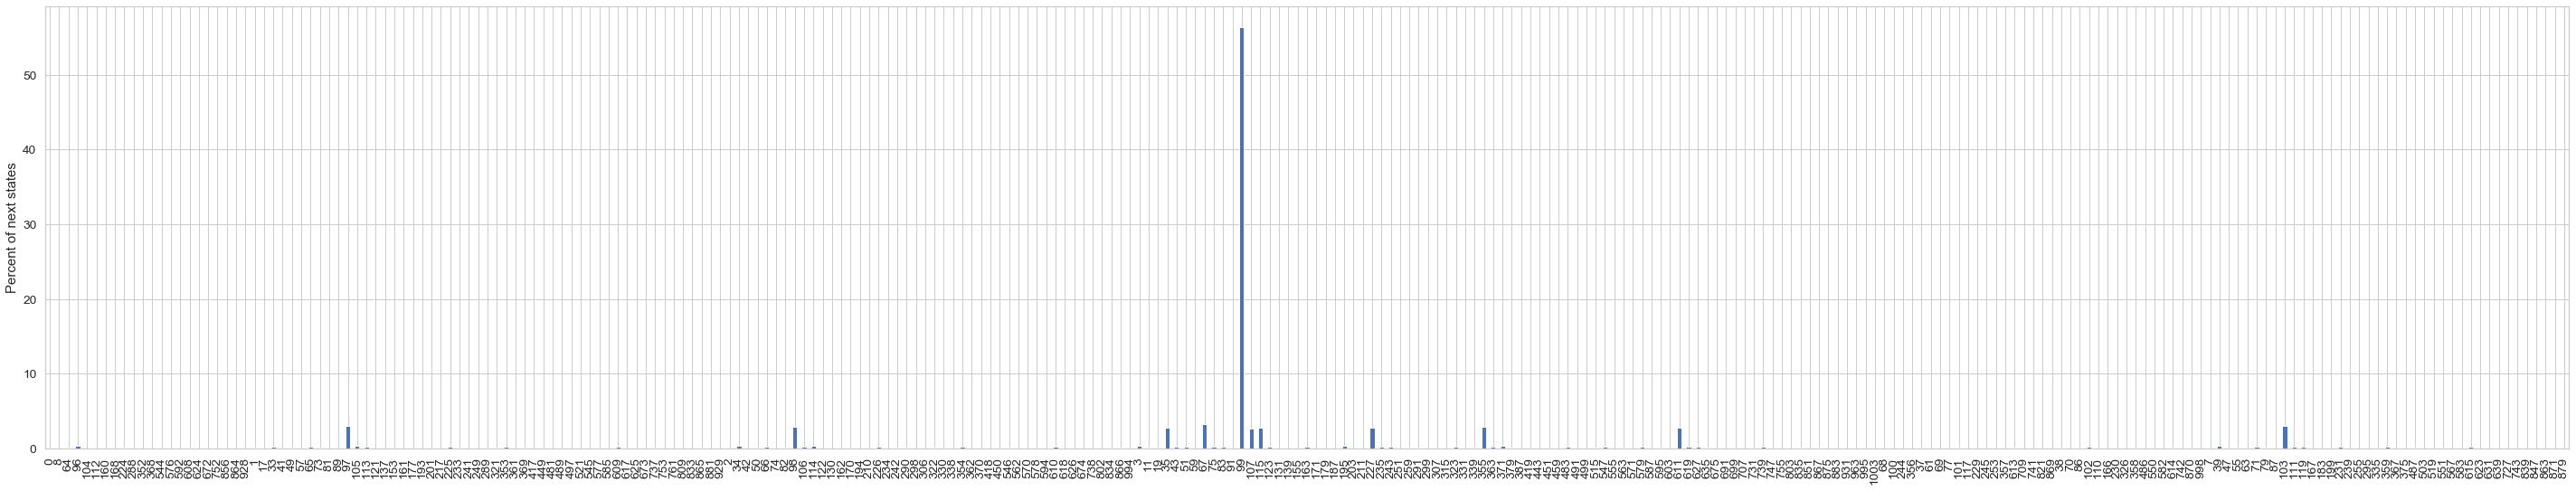

In [30]:
sns.set(style='whitegrid', rc={'figure.figsize':(50,9)}, font_scale=1.25)
ax = (tmp_df[tmp_df['alpha']=='1.0']['Next_Knowledge_State'].value_counts(normalize=True, sort=False)*100).plot.bar()
ax.set(ylabel="Percent of next states");

To check how the number of agents changes for state=99 over time we looked into distribution below. The ups and downs shows that while some agent may have been in state=99, they could still move to other states. However, it looks like number of agents that were state=99 were not less than initial t=0 at any other state. 

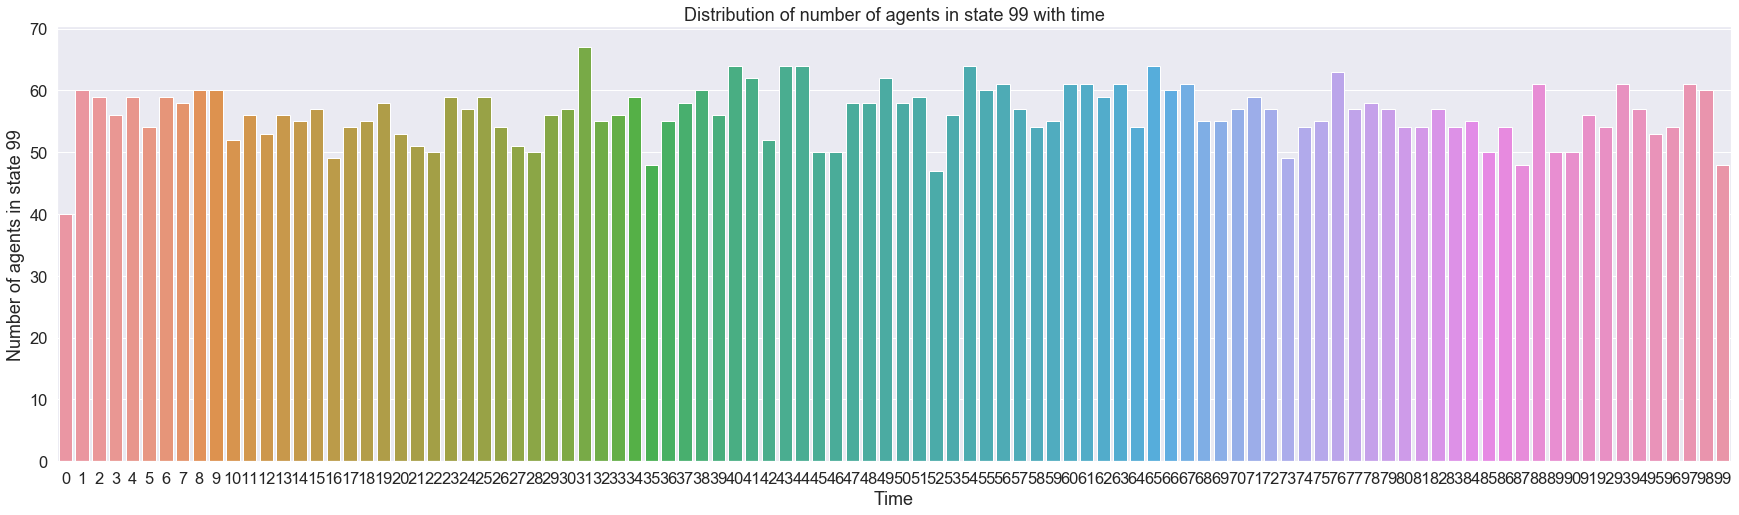

In [31]:
sns.set(style='darkgrid', rc={'figure.figsize':(30,8)}, font_scale=1.5)

sns.countplot(data=tmp_df[(tmp_df['alpha']=='1.0')&(tmp_df['Current_Knowledge_State']==99)], x='Time');
plt.title('Distribution of number of agents in state 99 with time')
plt.ylabel('Number of agents in state 99');

The analysis below is for computing probability of if an agent is on $state_i$, how likely it is to be in $state_j$. For e.g. we can see that if an agent is at state = 99, it seems around 75% of the time it stayed in same state. May be we can use these to build probablistic model and run other analysis. There is transition count as well so, we can weight the probability such that higher transition count and less transition count will be reflected in the model. 

In [32]:
x = tmp_df[tmp_df['alpha']=='1.0']
df2 = x.groupby(['Current_Knowledge_State','Next_Knowledge_State']).size().reset_index(name='transition percentage')
df2['Transition Count'] = df2['transition percentage']

a = df2.groupby('Current_Knowledge_State')['transition percentage'].transform('sum')
df2['transition percentage'] = df2['transition percentage'].div(a)*100
df2[['Current_Knowledge_State','Next_Knowledge_State', 'Transition Count', 'transition percentage']].sort_values('Transition Count', ascending=False)

Current_Knowledge_State  Next_Knowledge_State  Transition Count  \
461                        99                    99              4204   
464                        99                   103               142   
571                       103                    99               135   
92                         35                    99               133   
248                        67                    99               130   
452                        99                    67               124   
459                        99                    97               123   
361                        97                    99               121   
441                        99                    35               120   
521                        99                   611               119   
484                        99                   227               118   
722                       115                    99               117   
893                       227                    99               112   
471                        99                   115               111   
1349                      611                    99               110   
498                        99                   355               108   
1087                      355                    99               108   
645                       107                    99               107   
467                        99                   107               103   
402                        98                    99               102   
240                        67                    67                98   
460                        99                    98                96   
1102                      355                   355                80   
401                        98                    98                80   
359                        97                    97                78   
905                       227                   227                72   
574                       103                   103                71   
1368                      611                   611                70   
729                       115                   115                66   
649                       107                   107                66   
...                       ...                   ...               ...   
616                       105                   803                 1   
615                       105                   353                 1   
614                       105                   291                 1   
613                       105                   235                 1   
612                       105                   115                 1   
609                       105                   104                 1   
606                       105                    73                 1   
605                       105                    43                 1   
604                       104                   107                 1   
603                       104                    99                 1   
626                       106                   119                 1   
628                       106                   233                 1   
664                       107                   491                 1   
629                       106                   354                 1   
663                       107                   487                 1   
662                       107                   379                 1   
661                       107                   367                 1   
658                       107                   353                 1   
657                       107                   251                 1   
652                       107                   114                 1   
650                       107                   110                 1   
642                       107                    96                 1   
641                       107                    91             